In [1]:
from transformers import CLIPProcessor, CLIPModel
import torch
import torchvision
from torchvision.models import resnet50
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import clip
from PIL import Image
import requests
import torch.hub
import time
import pickle
import math
from torch.autograd import Variable

from utils import matching, stats, proggan, nethook, zdataset

ModuleNotFoundError: No module named 'transformers'

In [2]:
device = torch.device('cuda:0')

In [3]:
clipmodel, preprocess = clip.load("RN50", device=device)
clip_layers = [ "visual.layer1", "visual.layer2", "visual.layer3", "visual.layer4"]
for p in clipmodel.parameters(): 
    p.data = p.data.float() 

/home/amildravid/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
text = clip.tokenize([ "A dog that is happy outside"]).to(device)


In [5]:
image = preprocess(Image.open("./golden_retriever/image/golden_retriever.png")).unsqueeze(0).to(device)

In [6]:
text = clip.tokenize(["dog"]).to(device)
text_features = clipmodel.encode_text(text).detach()
#text_features = text_features / text_features.norm(dim=1, keepdim=True)
#logit_scale = torch.nn.Parameter(torch.ones([]) * np.log(1 / 0.07)).exp().detach()

In [7]:
inputs = Variable(torch.randn(1,3,224,224).to(device), requires_grad = True)
optim = torch.optim.Adam([inputs], lr=0.01, betas=(0.5, 0.999))  

In [8]:
from torch.nn import CosineSimilarity
cossim = CosineSimilarity(dim=0, eps=1e-6)

In [9]:
for epoch in range(0,100000):
    optim.zero_grad()
    
    image_features = clipmodel.encode_image(inputs)
    image_features = image_features / image_features.norm(dim=1, keepdim=True)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)
    loss = -1*image_features @ text_features.t()
    #print(loss)
    #loss = cossim(image_features.flatten(), text_features.flatten())
    
    if (epoch+1)%100 == 0:
        print("E:", epoch+1, "loss:", loss)
        
    loss.backward()
    optim.step()

E: 100 loss: tensor([[-0.4209]], device='cuda:0', grad_fn=<MmBackward0>)
E: 200 loss: tensor([[-0.4497]], device='cuda:0', grad_fn=<MmBackward0>)
E: 300 loss: tensor([[-0.4702]], device='cuda:0', grad_fn=<MmBackward0>)
E: 400 loss: tensor([[-0.4859]], device='cuda:0', grad_fn=<MmBackward0>)
E: 500 loss: tensor([[-0.4873]], device='cuda:0', grad_fn=<MmBackward0>)
E: 600 loss: tensor([[-0.5180]], device='cuda:0', grad_fn=<MmBackward0>)
E: 700 loss: tensor([[-0.5151]], device='cuda:0', grad_fn=<MmBackward0>)
E: 800 loss: tensor([[-0.5497]], device='cuda:0', grad_fn=<MmBackward0>)
E: 900 loss: tensor([[-0.5687]], device='cuda:0', grad_fn=<MmBackward0>)
E: 1000 loss: tensor([[-0.5869]], device='cuda:0', grad_fn=<MmBackward0>)
E: 1100 loss: tensor([[-0.5825]], device='cuda:0', grad_fn=<MmBackward0>)
E: 1200 loss: tensor([[-0.5971]], device='cuda:0', grad_fn=<MmBackward0>)
E: 1300 loss: tensor([[-0.5993]], device='cuda:0', grad_fn=<MmBackward0>)
E: 1400 loss: tensor([[-0.6271]], device='cuda:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


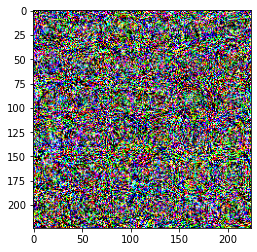

In [10]:
plt.imshow(torch.permute(inputs[0].cpu().detach(), (1,2,0)))

In [27]:
clip

<module 'clip' from '/home/amildravid/.local/lib/python3.8/site-packages/clip/__init__.py'>

In [29]:
clipmodel, preprocess = clip.load("RN50", device=device)

In [31]:
text = clip.tokenize(["dog", "cat", "noise", "rainbow", "color"]).to(device)


image_features = clipmodel.encode_image(inputs)
text_features = clipmodel.encode_text(text)


image_features = image_features / image_features.norm(dim=1, keepdim=True)
text_features = text_features / text_features.norm(dim=1, keepdim=True)
loss = image_features @ text_features.t()

print(loss)




logits_per_image, logits_per_text = clipmodel(inputs, text)
probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
print("Label probs:", probs)

tensor([[0.9536, 0.8643, 0.7886, 0.7222, 0.7920]], device='cuda:0',
       dtype=torch.float16, grad_fn=<MmBackward0>)
Label probs: [[1.000e+00 1.314e-04 5.960e-08 0.000e+00 1.192e-07]]


In [12]:
from utils import matching

In [13]:
inputs.shape

torch.Size([1, 3, 224, 224])

In [100]:
clipmodel, preprocess = clip.load("RN50", device=device)
clip_layers = [ "visual.layer1", "visual.layer2", "visual.layer3", "visual.layer4"]
for p in clipmodel.parameters(): 
    p.data = p.data.float() 
    
clipmodel = nethook.InstrumentedModel(clipmodel)
clipmodel.retain_layers(clip_layers)

In [15]:
#inputs = image
_ = clipmodel.model.encode_image(inputs)
clip_activs = {}
for layer in clip_layers:
    clip_activs[layer] = []
    clip_activation = clipmodel.retained_layer(layer, clear = True)
    clip_activs[layer].append(clip_activation)

In [16]:
clip_stats = []
for layer in clip_layers:
    clip_activs[layer] = torch.cat(clip_activs[layer], 0)
    clip_activs[layer] = torch.permute(clip_activs[layer], (1,0,2,3)).contiguous()
    clip_activs[layer] = clip_activs[layer].view(clip_activs[layer].shape[0], -1)
    clip_stats.append([torch.mean(clip_activs[layer], dim=-1, dtype=torch.float64).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device),\
                                      torch.std(clip_activs[layer], dim=-1).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device)])


In [17]:
clip_means = []
clip_stds = []
for iii, layer in enumerate(clip_stats):
    clip_means.append(clip_stats[iii][0].flatten().unsqueeze(0))
    clip_stds.append(clip_stats[iii][1].flatten().unsqueeze(0))

clip_means = torch.cat(clip_means,1)
clip_stds = torch.cat(clip_stds,1)

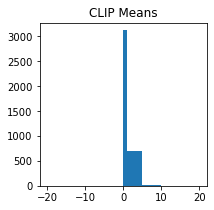

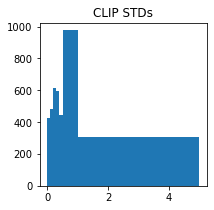

In [18]:
fig, ax = plt.subplots(figsize =(3, 3))
ax.hist(clip_means.cpu(), bins = [-20, -10, -5, -1, 0, 1, 5, 10, 20])
plt.title("CLIP Means")
plt.show()
    
    
fig, ax = plt.subplots(figsize =(3, 3))
ax.hist(clip_stds.cpu(), bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5,1, 5])
plt.title("CLIP STDs")
# plt.xticks(np.arange(0, 1, 0.1), size =5)
plt.show()

In [19]:
val, clipidx = torch.topk(clip_means, k=50)
print(val)
print(clipidx)

tensor([[16.5874, 10.2631,  8.8429,  7.9167,  7.9045,  7.8014,  7.6646,  7.4526,
          7.3335,  7.2375,  6.8390,  6.7471,  6.6848,  6.5567,  6.0640,  5.9021,
          5.8494,  5.7933,  5.7908,  5.5705,  5.5019,  5.4541,  5.3747,  5.3373,
          5.2690,  5.0879,  5.0681,  4.8731,  4.7519,  4.7150,  4.6245,  4.6077,
          4.4857,  4.3874,  4.3500,  4.3170,  4.2345,  4.1444,  4.1225,  4.1121,
          4.0912,  4.0845,  4.0844,  4.0564,  4.0048,  3.9840,  3.9801,  3.9598,
          3.9489,  3.9130]], device='cuda:0', dtype=torch.float64)
tensor([[1109, 1246, 1278, 1607,  924, 1191, 1456, 1999, 1039, 1397, 1000,  521,
           83,  873,  863, 3161, 2924, 1673, 1219, 1164, 1308, 1455, 3019,  437,
          920, 2740,  255, 1989, 1970, 1309,  619,   82,  488,  936, 3117,  591,
          293,  654,  756, 1336, 1223, 1300,  353,  794,  422, 1430, 1293, 1464,
          495,  465]], device='cuda:0')


In [20]:
all_clip_layers = {}
for jjj, clip_activ in enumerate(list(clip_activs.values())):
    print(clip_activ.shape)
    all_clip_layers[clip_layers[jjj]] = clip_activ.shape[0]

torch.Size([256, 3136])
torch.Size([512, 784])
torch.Size([1024, 196])
torch.Size([2048, 49])


In [97]:
from utils import layers
idx = layers.find_act(2924, all_clip_layers)
#idx = layers.find_act(clipidx[0][0].item(), all_clip_layers)

In [98]:
idx

(3, 1132)

In [54]:
all_clip_layers

{'visual.layer1': 256,
 'visual.layer2': 512,
 'visual.layer3': 1024,
 'visual.layer4': 2048}

In [43]:
inputs = image
_ = clipmodel.model.encode_image(inputs)
clip_activs = {}
for layer in clip_layers:
    clip_activs[layer] = []
    clip_activation = clipmodel.retained_layer(layer, clear = True)
    clip_activs[layer].append(clip_activation)

In [46]:
clip_activs['visual.layer3'][0].shape

torch.Size([1, 1024, 14, 14])

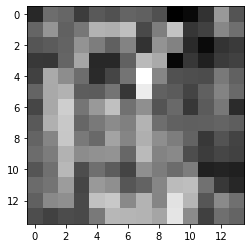

In [51]:
plt.imshow(clip_activs['visual.layer3'][0][0,341].cpu().detach(),cmap="gray")

In [52]:
torch.mean(clip_activs['visual.layer3'][0][0,341])

tensor(16.7876, device='cuda:0')

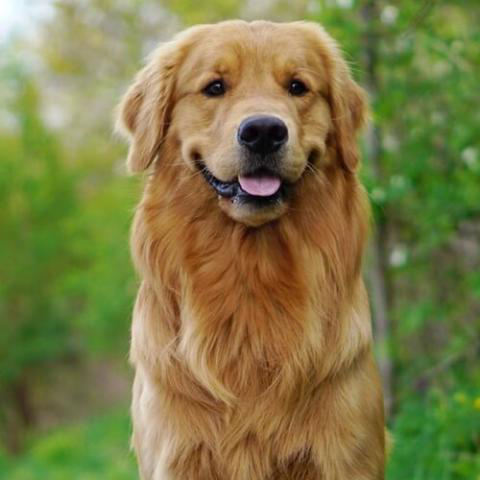

In [53]:
Image.open("./golden_retriever/image/golden_retriever.png")

In [129]:
#inputs = image
_ = clipmodel.model.encode_image(inputs)
clip_activs = {}
for layer in clip_layers:
    clip_activs[layer] = []
    clip_activation = clipmodel.retained_layer(layer, clear = True)
    clip_activs[layer].append(clip_activation)

In [130]:
clip_stats = []
for layer in clip_layers:
    clip_activs[layer] = torch.cat(clip_activs[layer], 0)
    clip_activs[layer] = torch.permute(clip_activs[layer], (1,0,2,3)).contiguous()
    clip_activs[layer] = clip_activs[layer].view(clip_activs[layer].shape[0], -1)
    a,_ = torch.max(clip_activs[layer], dim=-1)
    a = a.unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device)
    clip_stats.append([a])


In [131]:
clip_max = []
for iii, layer in enumerate(clip_stats):
    clip_max.append(clip_stats[iii][0].flatten().unsqueeze(0))
    
clip_max = torch.cat(clip_max,1)


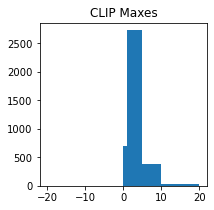

In [132]:
fig, ax = plt.subplots(figsize =(3, 3))
ax.hist(clip_max.cpu(), bins = [-20, -10, -5, -1, 0, 1, 5, 10, 20])
plt.title("CLIP Maxes")
plt.show()


In [133]:
val, clipidx = torch.topk(clip_max, k=50)
print(val)
print(clipidx)

tensor([[25.6208, 23.4002, 22.7052, 20.7552, 20.5552, 19.6796, 17.9450, 17.6526,
         17.4106, 17.2598, 16.3138, 15.5811, 15.3530, 15.1115, 15.0197, 14.2318,
         13.8164, 12.9983, 12.6814, 12.4159, 12.0964, 11.9858, 11.9118, 11.5404,
         11.3947, 11.3880, 11.3091, 11.2027, 10.9770, 10.7071, 10.4566, 10.3485,
         10.2425, 10.2342, 10.2286, 10.1860, 10.1800, 10.1751, 10.0112,  9.9994,
          9.9753,  9.8879,  9.8786,  9.8709,  9.7860,  9.7554,  9.6219,  9.5844,
          9.5663,  9.5524]], device='cuda:0')
tensor([[2740,   82, 2574, 1999, 3019, 2924, 2800, 2774, 1109, 1970, 2280, 3608,
         3232, 1989, 3624,   83, 3161, 3117, 3168, 2823,  432, 3678,  631,  209,
         2119,  285, 2758, 1246, 2207,  151, 1831, 2326, 2158, 3270, 2432, 2010,
         3735, 2945, 2528, 1278,  391,  635, 3335, 3373, 2935, 2345, 3056, 3616,
            6, 2045]], device='cuda:0')


In [149]:
layers.find_act(3168, all_clip_layers)

(3, 1376)